In [1]:
import numpy as np
import pandas as pd

import operator
import random
import math

# from dataclasses import dataclass
from functools import partial
# from copy import deepcopy

from deap import gp, base, creator, tools, algorithms

# from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
import seaborn as sns



In [2]:
PATH_TRAIN = "./data/train.csv"
PATH_TEST = "./data/test.csv"

DTYPES_FEATURES = {
          "id": "uint64",
          "fr_COO": "category",
          "fr_COO2": "category",
      }

DTYPES_TARGETS = {
          "EC1": "bool",
          "EC2": "bool",
          "EC3": "bool",
          "EC4": "bool",
          "EC5": "bool",
          "EC6": "bool"
}

DROP_COLS = ["EC3", "EC4", "EC5", "EC6"]



def _load_data(datapath: str, dtypes: dict, drop_cols: list) -> pd.DataFrame:
  return pd.read_csv(
      filepath_or_buffer=datapath,
      dtype=dtypes,
      index_col="id"
    ).drop(columns=drop_cols, axis=1)


GetTrainDF = partial(_load_data, datapath=PATH_TRAIN, dtypes=dict(**DTYPES_TARGETS, **DTYPES_FEATURES), drop_cols=DROP_COLS)
GetTestDF = partial(_load_data, datapath=PATH_TEST, dtypes=DTYPES_FEATURES, drop_cols=[])

df_train = GetTrainDF().astype(float)
df_train

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2
id,,,,,,,,,,,,,,,,,,,,,
0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,...,0.000000,0.000000,17.744066,0.000000,4.794537,35.527357,0.0,0.0,1.0,1.0
1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,...,0.000000,0.000000,7.822697,30.705892,13.825658,44.707310,0.0,0.0,0.0,1.0
2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,...,53.378235,0.000000,15.645394,73.143616,17.964475,45.660120,0.0,0.0,1.0,1.0
3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,...,0.000000,6.420822,15.645394,62.107304,31.961948,87.509997,0.0,0.0,1.0,1.0
4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,...,19.386400,0.000000,11.938611,18.883484,9.589074,33.333333,2.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14833,632.207041,10.911303,6.579933,9.179964,4.653583,6.030052,3.670528,1.770579,32.971529,6.606882,...,13.847474,6.923737,34.407699,32.607024,18.947452,61.376610,0.0,0.0,1.0,1.0
14834,62.568425,2.642734,1.446898,1.446898,0.879497,0.879497,0.174620,0.000000,0.000000,0.000000,...,0.000000,6.066367,0.000000,6.420822,0.000000,10.000000,0.0,0.0,0.0,1.0
14835,981.327476,10.363081,6.146219,6.146219,4.700576,4.700576,3.064846,2.133897,17.248535,0.000000,...,0.000000,23.762553,10.969244,0.000000,0.000000,66.666667,0.0,0.0,1.0,1.0


In [3]:
# names (=argn) and number (=argc) of arguments

argn = df_train.drop(columns=["EC1", "EC2"], inplace=False).columns.to_list()
argc = len(argn)

In [4]:
pset = gp.PrimitiveSet("MAIN", arity=argc, prefix="ARG")

pset.renameArguments(**{f"ARG{i}": arg for i, arg in enumerate(argn)})

def protectedDiv(left, right):
    if right == 0:
        return 1
    else:
         return left / right
    
def if_lt(a, b, c, d):
    if a < b:
        return c
    else:
        return d
    
pset.addPrimitive(if_lt, 4, name="if_lt")
pset.addPrimitive(protectedDiv, 2, name="div")
pset.addPrimitive(operator.add, 2, name="add")
pset.addPrimitive(operator.sub, 2, name="sub")
pset.addPrimitive(operator.mul, 2, name="mul")
pset.addPrimitive(operator.neg, 1, name="neg")
pset.addPrimitive(math.cos, 1, name="cos")
pset.addPrimitive(math.sin, 1, name="sin")
pset.addEphemeralConstant("rand101", lambda: random.randint(-10,10))

In [5]:
# create a fitness and individual

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [6]:
# create a toolbox

toolbox_ec1 = base.Toolbox()
toolbox_ec2 = base.Toolbox()


In [7]:
# create a X and y

X = df_train.drop(columns=["EC1", "EC2"], inplace=False).values
y_ec1 = df_train["EC1"].values.astype(int)
y_ec2 = df_train["EC2"].values.astype(int)


In [8]:
# create a fitness function that takes an individual as input and returns the corresponding auc score

def evalBinaryClassification(individual, X, y):
    
    func = gp.compile(expr=individual, pset=pset)
    y_pred_vals = np.array([func(*x) for x in X])
    # replace all values < 0 with 0, and all values > 1 with 1, nan with 0
    y_pred_vals = np.nan_to_num(y_pred_vals, copy=True, nan=0.0, posinf=1.0, neginf=0.0)
    y_pred_vals[y_pred_vals < 0] = 0
    y_pred_vals[y_pred_vals > 1] = 1

    return roc_auc_score(y, y_pred_vals.astype(int)),


In [9]:
# set up the toolbox for the gp algorithm on the ec1 target

toolbox_ec1.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox_ec1.register("individual", tools.initIterate, creator.Individual, toolbox_ec1.expr)
toolbox_ec1.register("population", tools.initRepeat, list, toolbox_ec1.individual)


toolbox_ec1.register("select", tools.selTournament, tournsize=3)
toolbox_ec1.register("mate", gp.cxOnePoint)
toolbox_ec1.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox_ec1.register("mutate", gp.mutUniform, expr=toolbox_ec1.expr_mut, pset=pset)
toolbox_ec1.register("compile", gp.compile, pset=pset)
toolbox_ec1.register("evaluate", evalBinaryClassification, X=X, y=y_ec1)

# bloat control
toolbox_ec1.decorate(
    "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)
toolbox_ec1.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)

# set up the toolbox for the gp algorithm on the ec2 target

toolbox_ec2.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox_ec2.register("individual", tools.initIterate, creator.Individual, toolbox_ec2.expr)
toolbox_ec2.register("population", tools.initRepeat, list, toolbox_ec2.individual)


toolbox_ec2.register("select", tools.selTournament, tournsize=3)
toolbox_ec2.register("mate", gp.cxOnePoint)
toolbox_ec2.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox_ec2.register("mutate", gp.mutUniform, expr=toolbox_ec2.expr_mut, pset=pset)
toolbox_ec2.register("compile", gp.compile, pset=pset)
toolbox_ec2.register("evaluate", evalBinaryClassification, X=X, y=y_ec2)

toolbox_ec2.decorate(
    "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)
toolbox_ec2.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)

In [10]:
# statistics dictionary
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


In [11]:
# run the algorithm on the ec1 target

# evolutionary parameters
NGEN_EC1 = 100
POPSIZE_EC1 = 500
CXPB_EC1 = 0.9
MUTPB_EC1 = 0.1

pop_ec1 = toolbox_ec1.population(n=POPSIZE_EC1)
hof_ec1 = tools.HallOfFame(1)


pop_ec1, log_ec1 = algorithms.eaSimple(pop_ec1, toolbox_ec1, CXPB_EC1, MUTPB_EC1, NGEN_EC1, stats=stats, halloffame=hof_ec1, verbose=True)

# print the best individual
print(hof_ec1[0])

# save the winner program
f_ec1_raw = gp.compile(hof_ec1[0], pset)

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.498079	0.0288118	0.396904	0.596904
1  	784   	0.508295	0.0315609	0.391245	0.599093
2  	786   	0.517828	0.035498 	0.397719	0.597758
3  	813   	0.523386	0.0398074	0.386297	0.600906
4  	806   	0.534736	0.0414688	0.386297	0.626838
5  	810   	0.54263 	0.0424184	0.394798	0.610814
6  	819   	0.550158	0.0419842	0.413426	0.604828
7  	812   	0.55722 	0.0426613	0.397038	0.622165
8  	839   	0.562841	0.0438731	0.402358	0.616565
9  	823   	0.568332	0.0429038	0.42054 	0.62077 
10 	816   	0.570406	0.0440781	0.396079	0.627658
11 	876   	0.573342	0.0422989	0.41554 	0.627658
12 	818   	0.578674	0.0382651	0.428506	0.621269
13 	802   	0.581028	0.0383958	0.407738	0.622908
14 	834   	0.582892	0.0376049	0.417834	0.628503
15 	826   	0.585239	0.0398297	0.42227 	0.63186 
16 	790   	0.591802	0.037236 	0.432027	0.63186 
17 	814   	0.5936  	0.039385 	0.390544	0.634439
18 	789   	0.597737	0.0361545	0.431434	0.634439
19 	829   	0.600524	0.0365851	0.435965	0

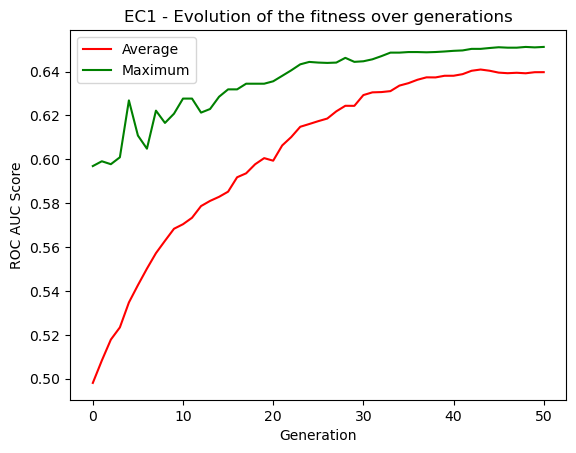

In [15]:
# plot the evolution from the logbook log_ec1
# plot the average, max and std deviation of fitness
gen_ec1 = log_ec1.select("gen") 
fit_avgs_ec1 = log_ec1.select("avg")
fit_maxs_ec1 = log_ec1.select("max")

fig, ax1 = plt.subplots()
line2 = ax1.plot(gen_ec1, fit_avgs_ec1, "r-", label="Average")
line3 = ax1.plot(gen_ec1, fit_maxs_ec1, "g-", label="Maximum")

ax1.set_xlabel("Generation")
ax1.set_ylabel("ROC AUC Score")

ax1.set_title("EC1 - Evolution of the fitness over generations")

ax1.legend()


plt.show()




In [13]:
# run the algorithm on the ec2 target

# evolutionary parameters
NGEN_EC2 = 100
POPSIZE_EC2 = 500
CXPB_EC2 = 0.9
MUTPB_EC2 = 0.1

pop_ec2 = toolbox_ec2.population(n=POPSIZE_EC2)
hof_ec2 = tools.HallOfFame(1)


pop_ec2, log_ec2 = algorithms.eaSimple(pop_ec2, toolbox_ec2, CXPB_EC2, MUTPB_EC2, NGEN_EC2, stats=stats, halloffame=hof_ec2, verbose=True)

# print the best individual
print(hof_ec2[0])


# save the winner program
f_ec2_raw = gp.compile(hof_ec2[0], pset)


gen	nevals	avg   	std      	min     	max     
0  	1000  	0.4988	0.0119531	0.439046	0.551751
1  	828   	0.504072	0.0127515	0.448839	0.551751
2  	805   	0.509288	0.014559 	0.457091	0.552826
3  	841   	0.513738	0.0169495	0.44235 	0.552826
4  	846   	0.519727	0.0175751	0.448839	0.552826
5  	803   	0.526361	0.0187805	0.453973	0.554895
6  	809   	0.532048	0.019928 	0.448249	0.555022
7  	815   	0.535726	0.0211412	0.451525	0.559348
8  	808   	0.539112	0.0205036	0.448839	0.562517
9  	808   	0.540523	0.0201492	0.455348	0.562602
10 	817   	0.54076 	0.0203144	0.448249	0.56373 
11 	810   	0.542114	0.0201685	0.448249	0.565608
12 	814   	0.544854	0.0184452	0.479882	0.564766
13 	794   	0.547657	0.0175467	0.448839	0.564766
14 	842   	0.549631	0.0172283	0.469629	0.567287
15 	813   	0.551704	0.0175831	0.447043	0.566612
16 	829   	0.552987	0.0172005	0.479053	0.566612
17 	858   	0.553371	0.0172342	0.479244	0.566654
18 	804   	0.555373	0.0162127	0.495216	0.566654
19 	823   	0.555693	0.0166531	0.493064	0.567

KeyboardInterrupt: 

In [16]:
# plot the evolution from the logbook log_ec1
# plot the average, max and std deviation of fitness
gen_ec2 = log_ec2.select("gen") 
fit_avgs_ec2 = log_ec2.select("avg")
fit_maxs_ec2 = log_ec2.select("max")

fig, ax1 = plt.subplots()
line2 = ax1.plot(gen_ec2, fit_avgs_ec2, "r-", label="Average")
line3 = ax1.plot(gen_ec2, fit_maxs_ec2, "g-", label="Maximum")

ax1.set_xlabel("Generation")
ax1.set_ylabel("ROC AUC Score")

for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax1.set_title("EC2 - Evolution of the fitness over generations")
ax1.legend()

plt.show()



NameError: name 'log_ec2' is not defined

# Best Programs

## EC1

`div(add(MaxAbsEStateIndex, if_lt(EState_VSA2, MinEStateIndex, MaxAbsEStateIndex, add(fr_COO, add(if_lt(Chi4n, MinEStateIndex, PEOE_VSA7, FpDensityMorgan1), add(div(sin(sin(EState_VSA1)), add(if_lt(mul(PEOE_VSA6, PEOE_VSA10), if_lt(PEOE_VSA10, MinEStateIndex, PEOE_VSA7, add(mul(PEOE_VSA6, fr_COO), Chi4n)), PEOE_VSA14, FpDensityMorgan2), mul(PEOE_VSA6, PEOE_VSA10))), div(if_lt(sin(MinEStateIndex), fr_COO, div(if_lt(sin(MinEStateIndex), fr_COO, div(add(MaxAbsEStateIndex, if_lt(PEOE_VSA6, fr_COO2, PEOE_VSA7, add(mul(PEOE_VSA6, PEOE_VSA10), Chi4n))), fr_COO), mul(PEOE_VSA6, PEOE_VSA10)), Chi3v), mul(PEOE_VSA6, PEOE_VSA10)), Chi3v)))))), EState_VSA1)`

roc_auc_score: 0.651203